# <font color ='pickle'>Stack Excahnge Question Tags Multi-Label Classification

# <font size = 5, color = 'pickle'>**Task: Given title and body of the question, predict all the Question Tags (technical Domain).** 







# <Font color = 'pickle'>**Load Libraries/Install Software**

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    !pip install torchtext - -upgrade
    !pip install torchmetrics

    basepath = '/content/drive/MyDrive/data'
    sys.path.append('/content/drive/MyDrive/Applied Natural Language Processing/Assignments/HW6')

Mounted at /content/drive

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -u
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 10.2 MB/s eta 0:00:00


In [ ]:
pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 KB 3.3 MB/s eta 0:00:00


In [ ]:
# Importing the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.vocab import  vocab
import torchmetrics
from torchmetrics.classification import Accuracy, F1Score
import numpy as np
import pandas as pd
from collections import Counter
from pathlib import Path
import sys
from sklearn.model_selection import train_test_split
from types import SimpleNamespace
from functools import partial
from sklearn.metrics import accuracy_score, f1_score
from torchmetrics.classification import  MultilabelHammingDistance
import torch.optim as optim
from  torchmetrics.functional.classification import multilabel_f1_score, multilabel_hamming_distance
import torch.nn.init as init
from pathlib import Path
from sklearn.preprocessing import MultiLabelBinarizer

# <Font color = 'pickle'>**Specify Project Folders**

In [ ]:
model_folder = Path('/content/drive/MyDrive/models/nlp_spring_2023/hw6')
model_folder.mkdir(exist_ok=True)

In [ ]:
base_folder = Path(basepath)
hw6_folder = base_folder/'Applied Natural Language Processing/Assignments/HW6'

In [ ]:
sys.path

['/content',
 '/env/python',
 '/usr/lib/python39.zip',
 '/usr/lib/python3.9',
 '/usr/lib/python3.9/lib-dynload',
 '',
 '/usr/local/lib/python3.9/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.9/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/Applied Natural Language Processing/Assignments/HW6']

In [ ]:
from Trainer_v2 import Trainer

# <Font color = 'pickle'>**SubSet Stack Exchange**</font>

This data is a subset of data from  Kaggle Competition (https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data). The given dataset actually contains the different questions asked in the StackExchange website for various technical domains. We have fetched only those question that contains the top 10 individual tags. Each question can have only one tag. This means that this is a multi-class classification problem. These are the ten categories for tags in the data.

| Tag    | Language|
| -------| --------|
| 0      | c#      |
| 1      | jave    |
| 2      | php     |
| 3      | javascript|
| 4      | android |
| 5      | jquery  |
| 6      | c++     |
| 7      | python  |
| 8      | asp.net |

## <Font color = 'pickle'>**Load the Dataset**

In [ ]:
import joblib

df_hw = joblib.load('/content/drive/MyDrive/Applied Natural Language Processing/Assignments/HW6/df_multilabel_hw_cleaned.joblib')

In [ ]:
df_hw.head()

,cleaned_text,Tags,Tag_Number
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]"
1,run javascript code server java code want run ...,java javascript,"[1, 3]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]"
3,run python script php server run nginx web ser...,php python,"[2, 7]"
4,advice write function m try write function res...,javascript jquery,"[3, 5]"


In [ ]:
import ast

df_hw['Tag_Number'] = df_hw['Tag_Number'].apply(lambda x: ast.literal_eval(x))
df_hw['Tag_Number'] = df_hw['Tag_Number'].apply(lambda x: [int(i) for i in x])


In [ ]:
mlb = MultiLabelBinarizer()
df_encoded = df_hw.join(pd.DataFrame(mlb.fit_transform(df_hw.pop('Tag_Number')),
                          columns=mlb.classes_,
                          index=df_hw.index))

In [ ]:
df_encoded

,cleaned_text,Tags,0,1,2,3,4,5,6,7,8,9
0,asp query stre dropdown webpage follow control...,c# asp.net,1,0,0,0,0,0,0,0,0,1
1,run javascript code server java code want run ...,java javascript,0,1,0,1,0,0,0,0,0,0
2,linq sql throw exception row find change hi li...,c# asp.net,1,0,0,0,0,0,0,0,0,1
3,run python script php server run nginx web ser...,php python,0,0,1,0,0,0,0,1,0,0
4,advice write function m try write function res...,javascript jquery,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
47422,take value edittext put decimal point all- wor...,java android,0,1,0,0,1,0,0,0,0,0
47423,listen phone state application nee liste phone...,java android,0,1,0,0,1,0,0,0,0,0
47424,android ui thread thread task want access main...,java android,0,1,0,0,1,0,0,0,0,0
47425,dynamic table row creation html javascript htm...,asp.net javascript,0,0,0,1,0,0,0,0,0,1


In [ ]:
X_final = df_encoded['cleaned_text'].values

In [ ]:
print(type(X_final), X_final.shape)

<class 'numpy.ndarray'> (47427,)


In [ ]:
y_final = df_encoded.iloc[:, 2:].values

In [ ]:
y_final

array([[1, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

## <Font color = 'pickle'>**Create Train/Test/Valid Split**


In [ ]:
X_train, x_valid_test, y_train, y_valid_test = train_test_split(X_final, y_final, test_size = 0.4)

In [ ]:
X_valid, X_test, y_valid, y_test = train_test_split(x_valid_test, y_valid_test, test_size = 0.5)

In [ ]:
print(type(X_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## <Font color = 'pickle'>**Custom Dataset Class**

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    """IMDB dataset."""

    def __init__(self, X, y):
        self.X = np.array(X)
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        text = self.X[idx]
        labels = self.y[idx]
        sample = (labels, text)
        
        return sample

In [ ]:
trainset = CustomDataset(X_train,y_train)
validset = CustomDataset(X_valid,y_valid)
testset = CustomDataset(X_test,y_test)

## <Font color = 'pickle'>**Create Vocab**

In [ ]:
def create_vocab(dataset, min_freq=1):
  counter = Counter()
  for (l_, text) in dataset:
    counter.update(str(text).split())
  my_vocab = vocab(counter, min_freq=min_freq)
  my_vocab.insert_token('<unk>', 0)
  my_vocab.set_default_index(0)
  return my_vocab

vocab should always be created based on trainset

In [ ]:
stack_vocab = create_vocab(trainset, min_freq = 5)

## <Font color = 'pickle'>**Collate_fn for Data Loaders**

In [ ]:
# Creating a lambda function objects that will be used to get the indices of words from vocab
def text_pipeline(x, vocab):
    """Converts text to a list of indices using a vocabulary dictionary"""
    return [vocab[token] for token in str(x).split()]

In [ ]:
def collate_batch(batch, vocab):
    labels, texts = zip(*batch)
    labels = torch.tensor(labels, dtype=torch.int64)
    list_of_list_of_indices = [text_pipeline(text, vocab) for text in texts]

    offsets = [0] + [len(i) for i in list_of_list_of_indices]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    texts = torch.cat([torch.tensor(i, dtype=torch.int64)
                      for i in list_of_list_of_indices])
    return (texts, offsets), labels


## <Font color = 'pickle'>**Data Loaders**

In [ ]:
def get_loaders(trainset, validset, batch_size_, collate_fn):

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_, shuffle=True,
                                               collate_fn=collate_fn)
    valid_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size_, shuffle=False,
                                               collate_fn=collate_fn)
    return train_loader, valid_loader


def get_test_loaders(testset, batch_size_, collate_fn):

    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size_,   shuffle=False,
                                              collate_fn=collate_fn)
    return test_loader


## <Font color = 'pickle'>**Model**

In [ ]:
from ff_3_layer_sequential_model import MLPCustom

# <Font color = 'pickle'>**Meta Data**

In [ ]:
hyperparameters = SimpleNamespace(
    EPOCHS=5,
    BATCH_SIZE=128,
    LEARNING_RATE=0.001,
    WEIGHT_DECAY=0.000,
    CLIP_TYPE='value',
    CLIP_VALUE=10,
    PATIENCE=5,
    EMBED_DIM=300,	
    VOCAB_SIZE=len(stack_vocab),
    OUTPUT_DIM=10,
    HIDDEN_DIM1=200,
    HIDDEN_DIM2=100,
    NON_LINEARITY=F.relu
)

# <Font color = 'pickle'>**Data Preparation**

In [ ]:
train_loader, valid_loader= get_loaders(trainset,validset,hyperparameters.BATCH_SIZE,partial(collate_batch, vocab = stack_vocab))
test_loader= get_test_loaders(testset,hyperparameters.BATCH_SIZE,partial(collate_batch, vocab = stack_vocab))

# <Font color = 'pickle'>**Trainer Configuration**

In [ ]:
model = MLPCustom(embed_dim = hyperparameters.EMBED_DIM, vocab_size=hyperparameters.VOCAB_SIZE, hidden_dim1=hyperparameters.HIDDEN_DIM1, 
                  hidden_dim2=hyperparameters.HIDDEN_DIM2, output_dim=hyperparameters.OUTPUT_DIM, non_linearity=hyperparameters.NON_LINEARITY)

init.kaiming_normal_(model.hidden_layer1.weight.data)
init.kaiming_normal_(model.hidden_layer2.weight.data)
init.kaiming_normal_(model.output_layer.weight.data)

# device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# loss_function
# loss_function = nn.MultiLabelSoftMarginLoss()
loss_function = nn.BCEWithLogitsLoss()


# optimizer
optimizer = optim.Adam(model.parameters(), lr=hyperparameters.LEARNING_RATE, weight_decay=hyperparameters.WEIGHT_DECAY)


# <Font color = 'pickle'>**Sanity Check**
- Check the loss without any training. For Cross entropy the expected value will be log(number of classes)

In [ ]:
for (text, offsets), targets, in train_loader:
  
  # move inputs and outputs to GPUs
  text = text.to(device)
  targets = targets.to(device)
  targets = targets.float()
  offsets = offsets.to(device)
  model.to(device)
  model.eval()
  # Forward pass
  output = model((text, offsets))
  loss = loss_function(output, targets)
  print(f'Actual loss: {loss}')
  break

print(f'Expected Theoretical loss: {np.log(10)}')

<ipython-input-26-e40c6ed30a8d>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  labels = torch.tensor(labels, dtype=torch.int64)


Actual loss: 0.6719632148742676
Expected Theoretical loss: 2.302585092994046


# <Font color = 'pickle'>**Training Model**

# **MultilabelHammingDistance metric**

# MultilabelHammingDistance is a metric from the torchmetrics library that measures the average Hamming distance between the predicted and true labels in a multilabel classification problem. The Hamming distance is simply the number of labels that differ between the predicted and true labels.

# In multilabel classification, each sample can have multiple labels, which makes it different from traditional classification problems where each sample can have only one label. In such problems, metrics like accuracy and F1 score do not provide a complete picture of the performance of the model since they assume only one correct label per sample. MultilabelHammingDistance overcomes this problem by taking into account all the labels associated with a sample.

# MultilabelHammingDistance is a good metric for multilabel classification problems because it directly measures the number of label differences between the predicted and true labels. This makes it a simple and interpretable metric that can be used to compare different models and select the best one. It is also robust to class imbalance and can handle cases where some labels are more important than others.

In [ ]:
trainer = Trainer(model, optimizer, loss_function, device)

In [ ]:
run_name = 'run1'
run_folder = model_folder/run_name
run_folder.mkdir(exist_ok=True)

# set loaders
trainer.set_loaders(train_loader, valid_loader)
train_metric = MultilabelHammingDistance(num_labels=10)
valid_metric = MultilabelHammingDistance(num_labels=10)

# set metric
trainer.set_metric(train_metric.to(device), valid_metric.to(device))

# set checkpoint
trainer.set_checkpoint(save_path=run_folder,
                       save_best=True, save_every_n_epochs=1)

trainer.set_early_stopping(patience=hyperparameters.PATIENCE)

trainer.set_gradient_clipping(hyperparameters.CLIP_TYPE, hyperparameters.CLIP_VALUE, norm_type=2)


In [ ]:
trainer.train(num_epochs=hyperparameters.EPOCHS, multilabel= True)

Epoch 1/5 - Train Loss: 0.5622, Train Metric: 0.2605, Train Time: 0:00:03.465118
Epoch 1/5 - Val Loss: 0.2407, Val Metric: 0.0750, Val Time: 0:00:00.865300

Epoch 2/5 - Train Loss: 0.2312, Train Metric: 0.0820, Train Time: 0:00:04.488951
Epoch 2/5 - Val Loss: 0.1672, Val Metric: 0.0602, Val Time: 0:00:00.813522

Epoch 3/5 - Train Loss: 0.1785, Train Metric: 0.0637, Train Time: 0:00:03.365640
Epoch 3/5 - Val Loss: 0.1468, Val Metric: 0.0543, Val Time: 0:00:01.058857

Epoch 4/5 - Train Loss: 0.1538, Train Metric: 0.0550, Train Time: 0:00:04.149250
Epoch 4/5 - Val Loss: 0.1337, Val Metric: 0.0502, Val Time: 0:00:01.400110

Epoch 5/5 - Train Loss: 0.1377, Train Metric: 0.0496, Train Time: 0:00:03.691928
Epoch 5/5 - Val Loss: 0.1249, Val Metric: 0.0464, Val Time: 0:00:00.803816



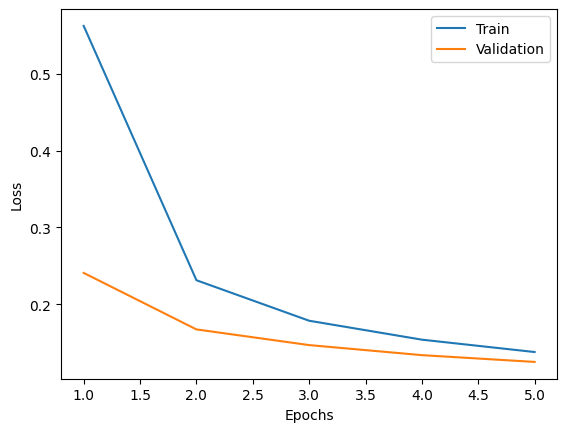

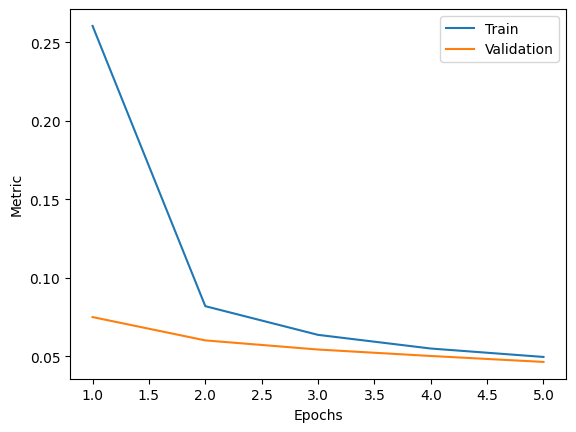

In [ ]:
trainer.plot_history()


# <Font color = 'pickle'>**More Epochs**

In [ ]:
lastfile = 'checkpoint_' + str(trainer.timestamp) + '_epoch_5.pt'
trainer.load_checkpoint(run_folder /lastfile)

Loaded checkpoint from '/content/drive/MyDrive/models/nlp_spring_2023/hw6/run1/checkpoint_2023-04-09_16-20-43_epoch_5.pt'.


In [ ]:
trainer.train(num_epochs=10, multilabel= True)

Epoch 1/10 - Train Loss: 0.1253, Train Metric: 0.0448, Train Time: 0:00:03.861129
Epoch 1/10 - Val Loss: 0.1173, Val Metric: 0.0436, Val Time: 0:00:01.384142

Epoch 2/10 - Train Loss: 0.1144, Train Metric: 0.0408, Train Time: 0:00:03.553824
Epoch 2/10 - Val Loss: 0.1125, Val Metric: 0.0418, Val Time: 0:00:00.791388

Epoch 3/10 - Train Loss: 0.1067, Train Metric: 0.0386, Train Time: 0:00:03.358542
Epoch 3/10 - Val Loss: 0.1085, Val Metric: 0.0401, Val Time: 0:00:00.793682

Epoch 4/10 - Train Loss: 0.0987, Train Metric: 0.0358, Train Time: 0:00:05.244291
Epoch 4/10 - Val Loss: 0.1067, Val Metric: 0.0388, Val Time: 0:00:00.966960

Epoch 5/10 - Train Loss: 0.0931, Train Metric: 0.0335, Train Time: 0:00:03.618874
Epoch 5/10 - Val Loss: 0.1052, Val Metric: 0.0378, Val Time: 0:00:00.803659

Epoch 6/10 - Train Loss: 0.0874, Train Metric: 0.0316, Train Time: 0:00:03.378085
Epoch 6/10 - Val Loss: 0.1033, Val Metric: 0.0372, Val Time: 0:00:01.481171

EarlyStopping counter: 1 out of 5
Epoch 7/10 -

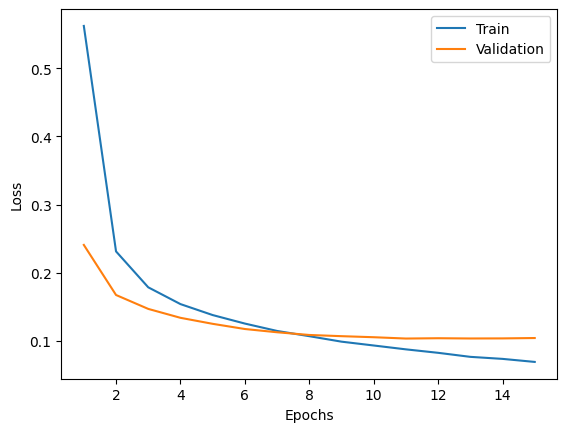

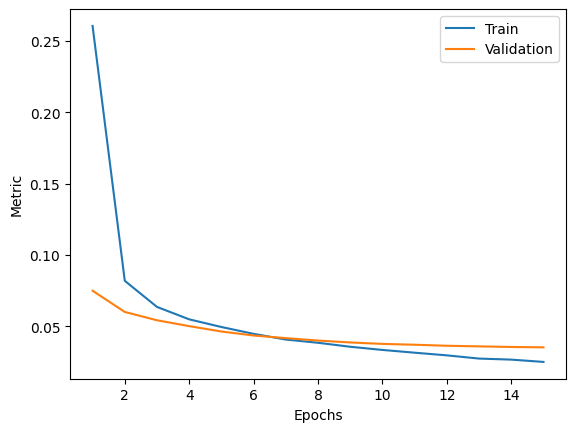

In [ ]:
trainer.plot_history()

# <Font color = 'pickle'>**Get Accuracy, Predictions**

In [ ]:
file = 'checkpoint_' + str(trainer.timestamp) + '_best.pt'
trainer.load_checkpoint(run_folder /file)

Loaded checkpoint from '/content/drive/MyDrive/models/nlp_spring_2023/hw6/run1/checkpoint_2023-04-09_16-20-43_best.pt'.


In [ ]:
# Get the prediction and accuracy for the test dataset

predictions_test, target_test = trainer.predict(test_loader, return_targets=True, multilabel=True)
predictions_train, target_train = trainer.predict(train_loader, return_targets=True, multilabel=True)
predictions_valid, target_valid = trainer.predict(valid_loader, return_targets=True, multilabel=True)

In [ ]:
print("Test set shapes: ", predictions_test.shape, target_test.shape)
print("Training set shapes: ", predictions_train.shape, target_train.shape)
print("Validation set shapes: ", predictions_valid.shape, target_valid.shape)

Test set shapes:  torch.Size([9486, 10]) torch.Size([9486, 10])
Training set shapes:  torch.Size([28456, 10]) torch.Size([28456, 10])
Validation set shapes:  torch.Size([9485, 10]) torch.Size([9485, 10])


In [ ]:
# Compute F1 score for all datasets

f1_test = multilabel_f1_score(predictions_test, target_test, num_labels=10)
f1_train = multilabel_f1_score(predictions_train, target_train, num_labels=10)
f1_valid = multilabel_f1_score(predictions_valid, target_valid, num_labels=10)

In [ ]:
# Compute Hamming distance for all datasets

hamming_test = multilabel_hamming_distance(predictions_test, target_test, num_labels=10)
hamming_train = multilabel_hamming_distance(predictions_train, target_train, num_labels=10)
hamming_valid = multilabel_hamming_distance(predictions_valid, target_valid, num_labels=10)

In [ ]:
# Print F1 Scores
print('Test f1score', f1_test * 100)
print('Train f1score', f1_train * 100)
print('Valid f1score', f1_valid * 100)

Test f1score tensor(81.2779)
Train f1score tensor(87.3615)
Valid f1score tensor(80.8541)


In [ ]:
# Print Hamming distance Scores
print('Test Hamming distance score', hamming_test )
print('Train Hamming distance score', hamming_train)
print('Valid Hamming distance score', hamming_valid)

Test Hamming distance score tensor(0.0352)
Train Hamming distance score tensor(0.0208)
Valid Hamming distance score tensor(0.0372)
